# Custom MLP Implementation on US Census Data

By: Joe Sellett, Haiyan Cai, and Cole Wagner

## Load, Split, and Balance Data

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
# Load the data as a pandas DataFrame
census_data = pd.read_csv("acs2017_census_tract_data.csv")

In [12]:
census_data.head()
census_data.shape

(74001, 37)

In [3]:
# Remove any rows with missing values
census_nona = census_data.dropna()

In [8]:
census_nona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  object 
 2   County            72718 non-null  object 
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float64
 17

In [ ]:
# Encode State column as integers

# Sort states alphabetically
unique_states = sorted(census_nona["State"].unique())
# Create a dictionary to map states to integers
state_to_int = {state: i + 1 for i, state in enumerate(unique_states)}
# Map the states to integers
census_nona["State"] = census_nona["State"].map(state_to_int)


/var/folders/jk/68j7w1pn443f9hrnsrlvphpw0000gn/T/ipykernel_24336/2895257612.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_nona["State"] = census_nona["State"].map(state_to_int)


In [11]:
census_nona["County"].value_counts()

County
Los Angeles County    2300
Cook County           1317
Orange County          929
Maricopa County        885
Montgomery County      822
                      ... 
Buena Vista city         1
Meagher County           1
Norton County            1
McCone County            1
Schleicher County        1
Name: count, Length: 1954, dtype: int64

In [13]:
# Drop the County column
census_nona = census_nona.drop(columns=["County"])

We decided to remove the County column due to the large number of categories. Using this in a model would require introducing almost 2000 columns into our dataset using one-hot encoding.

We believe that quantizing the data must be done separately for the training and testing data to prevent data leakage. We do not want the quantization of the testing data to be influenced by the training data. We will use the training data to determine the quantization bins and then apply the same bins to the testing data.

In [24]:
# Perform 80/20 train-test split
x_train, x_test, y_train, y_test = train_test_split(
    census_nona.drop(columns=["ChildPoverty"]),
    census_nona["ChildPoverty"],
    test_size=0.2,
    random_state=7324,
)

<Axes: >

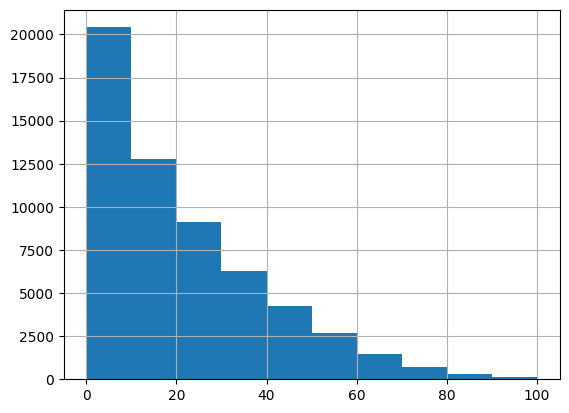

In [28]:
y_train.hist()

<Axes: >

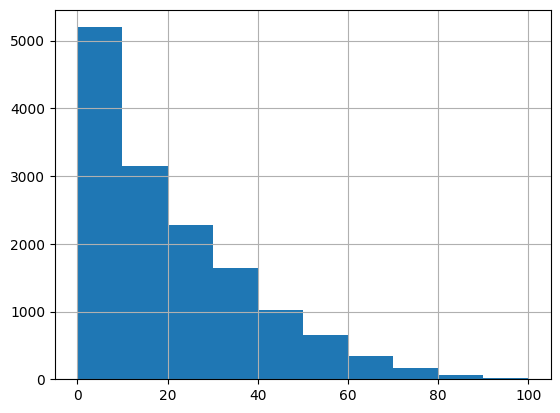

In [29]:
y_test.hist()

From the histograms above, we confirm that the distribution of ChildPoverty is similar in the training and testing sets.

In [34]:
# Quantize the training labels
y_train_cat, cuts = pd.qcut(
    y_train, q=4, labels=[1, 2, 3, 4], retbins=True
)

# Apply the same quantization to the test labels
y_test_cat = pd.cut(y_test, bins=cuts, labels=[1, 2, 3, 4])

## Preprocessing and Initial Modeling